In [143]:
from datetime import datetime, timedelta
import numpy as np
from scipy.linalg import sqrtm
import julian
from typing import Dict, List, Tuple, Any, Optional
import math
from numpy import linalg


import numpy as np
from typing import Dict, List
from datetime import datetime, timedelta


def parse_ephemeris_file(filename: str) -> Dict[str, np.ndarray]:
    """
    Parse ephemeris file with improved precision handling and convert covariances to EME2000.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    headers = {}
    for i in range(3):
        line = lines[i].strip()
        if ':' in line:
            key, value = line.split(':', 1)
            headers[key] = value.strip()
        if ' ' in line:
            parts = line.split()
            for part in parts:
                if ':' in part:
                    key, value = part.split(':', 1)
                    headers[key] = value.strip()
    
    if lines[3].strip() != 'UVW':
        raise ValueError("Expected UVW frame specification")
    
    timestamps: List[datetime] = []
    positions: List[np.ndarray] = []
    velocities: List[np.ndarray] = []
    covariances_uwv: List[np.ndarray] = []
    covariances_eme: List[np.ndarray] = []
    
    i = 4
    while i < len(lines):
        state_parts = lines[i].strip().split()
        
        # More precise timestamp parsing
        timestamp_str = state_parts[0]
        year = int(timestamp_str[:4])
        doy = int(timestamp_str[4:7])
        hour = int(timestamp_str[7:9])
        minute = int(timestamp_str[9:11])
        second = int(timestamp_str[11:13])
        millisec = int(timestamp_str[14:17])
        
        timestamp = datetime(year, 1, 1).replace(hour=hour, minute=minute,
                                               second=second, microsecond=millisec*1000) + \
                   timedelta(days=doy-1)
        
        # Use np.float64 for higher precision
        pos = np.array([np.float64(x) for x in state_parts[1:4]])
        vel = np.array([np.float64(x) for x in state_parts[4:7]])
        
        cov_values = []
        for j in range(3):
            cov_values.extend([np.float64(x) for x in lines[i+1+j].strip().split()])
        
        cov_matrix_uwv = np.zeros((6, 6), dtype=np.float64)
        idx = 0
        for row in range(6):
            for col in range(row + 1):
                cov_matrix_uwv[row, col] = cov_values[idx]
                cov_matrix_uwv[col, row] = cov_values[idx]
                idx += 1
        
        
        timestamps.append(timestamp)
        positions.append(pos)
        velocities.append(vel)
        covariances_uwv.append(cov_matrix_uwv)
        
        i += 4
    
    return {
        'headers': headers,
        'timestamps': np.array(timestamps),
        'positions': np.array(positions, dtype=np.float64),
        'velocities': np.array(velocities, dtype=np.float64),
        'covariances': np.array(covariances_uwv, dtype=np.float64),
    }



def get_interpolated_sigma_points(interpolated_splines: Dict,
                                julian_date: float) -> np.ndarray:
    """
    Get interpolated sigma points with high precision.
    """
    start_time, end_time = interpolated_splines['time_range']
    if not (start_time <= julian_date <= end_time):
        raise ValueError(f"Requested time {julian_date} is outside the interpolation range "
                        f"[{start_time}, {end_time}]")
    
    n_sigma_points = 13
    interpolated_points = np.zeros((n_sigma_points, 6), dtype=np.float64)
    
    for i in range(n_sigma_points):
        # Interpolate positions with high precision
        for j in range(3):
            if interpolated_splines['positions'][i][j] is not None:
                interpolated_points[i, j] = interpolated_splines['positions'][i][j](julian_date)
        
        # Interpolate velocities with high precision
        for j in range(3):
            if interpolated_splines['velocities'][i][j] is not None:
                interpolated_points[i, j+3] = interpolated_splines['velocities'][i][j](julian_date)
    
    return interpolated_points

def reconstruct_covariance_at_time(interpolated_points: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reconstruct the covariance matrix with improved numerical stability.
    """
    
    # Optimized Unscented Transform parameters
    n = 6
    alpha = np.float64(0.001)  # Reduced alpha for better numerical stability
    beta = np.float64(2.0)     # Optimal for Gaussian
    kappa = np.float64(3-n)    # Modified for better stability
    lambda_param = alpha * alpha * (n + kappa) - n

    # Precompute weights for efficiency and precision
    w0_m = lambda_param / (n + lambda_param)
    wn_m = np.float64(0.5) / (n + lambda_param)
    w0_c = w0_m + (1 - alpha * alpha + beta)
    wn_c = wn_m
        
    
    # Calculate mean state with improved precision
    mean_state = np.zeros(6, dtype=np.float64)
    mean_state = interpolated_points[0]
    #mean_state = w0_m * interpolated_points[0]
    #for i in range(1, len(interpolated_points)):
    #    mean_state += wn_m * interpolated_points[i]
    
    # Calculate covariance with improved numerical stability
    covariance = np.zeros((6, 6), dtype=np.float64)
    
    diff_0 = interpolated_points[0] - mean_state
    covariance = w0_c * np.outer(diff_0, diff_0)
    
    for i in range(1, len(interpolated_points)):
        diff = interpolated_points[i] - mean_state
        covariance += wn_c * np.outer(diff, diff)
        
    covariance = (covariance + covariance.T) / 2

    return mean_state, covariance


        
def generate_and_propagate_sigma_points(data: Dict[str, np.ndarray]) -> Optional[Dict[float, Dict]]:
    """
    Generate and propagate sigma points with improved numerical stability.
    """
    try:
        # Use high precision for Julian date conversion
        julian_dates = np.array([julian.to_jd(ts) for ts in data['timestamps']], dtype=np.float64)
        
        state_vectors = np.hstack((data['positions'], data['velocities']))
        covariances = data['covariances']
        
        sigma_points_dict = {}
        
        # Optimized Unscented Transform parameters
        n = 6
        alpha = np.float64(0.001)  # Reduced alpha for better numerical stability
        beta = np.float64(2.0)     # Optimal for Gaussian
        kappa = np.float64(3-n)    # Modified for better stability
        lambda_param = alpha * alpha * (n + kappa) - n
        
        # Precompute weights for efficiency and precision
        w0_m = lambda_param / (n + lambda_param)
        wn_m = np.float64(0.5) / (n + lambda_param)
        w0_c = w0_m + (1 - alpha * alpha + beta)
        wn_c = wn_m
        
        weights = {
            'mean': {'w0': w0_m, 'wn': wn_m},
            'covariance': {'w0': w0_c, 'wn': wn_c}
        }
        
        for idx, (jd, timestamp) in enumerate(zip(julian_dates, data['timestamps'])):
            try:
                state_vector = state_vectors[idx]
                covariance = covariances[idx]
                
                # Ensure symmetry of covariance matrix
                covariance = (covariance + covariance.T) / 2
                
                # Scale covariance matrix with improved numerical stability
                scaled_cov = (n+lambda_param) * covariance
                
                # Try Cholesky first, fall back to modified sqrtm if needed
                try:
                    L = np.linalg.cholesky(scaled_cov)
                except np.linalg.LinAlgError:
                    L = sqrtm(scaled_cov)
                
                sigma_0 = state_vector
                sigma_n = sigma_0[:, np.newaxis] + L
                sigma_2n = sigma_0[:, np.newaxis] - L
                
                all_sigma_points = np.vstack([
                                    sigma_0,
                                    sigma_n.T,
                                    sigma_2n.T
                                ])
                
                sigma_points_dict[jd] = {
                    'sigma_points': all_sigma_points,
                    'weights': weights,
                    'epoch': timestamp,
                    'state_vector': state_vector,
                    'covariance': covariance
                    }
                
            except Exception as e:
                print(f"Warning: Failed to process timestamp {timestamp}: {str(e)}")
                continue
        
        if not sigma_points_dict:
            raise ValueError("No sigma points were successfully generated")
        
        return sigma_points_dict
    
    except Exception as e:
        print(f"Error in generate_and_propagate_sigma_points: {str(e)}")
        return None

def skip_data_points(data: Dict[str, Any], skip_interval: int = 2, start_index: int = 0) -> Dict[str, Any]:
    """
    Returns data with regular intervals skipped for time series arrays
    
    Parameters:
        data: Dictionary containing ephemeris data
        skip_interval: Number of points to skip (default 2 means using indices 0,3,6,...)
        start_index: Index of the first point to include (default 0)
        
    Returns:
        Dictionary with filtered data arrays
    """
    filtered_data = data.copy()  # Create a copy of the dictionary
    
    # Skip points for the time series arrays starting from start_index
    skip_slice = slice(start_index, None, skip_interval + 1)
    #print(skip_slice)
    filtered_data['timestamps'] = data['timestamps'][skip_slice]
    #print(filtered_data['timestamps'])
    filtered_data['positions'] = data['positions'][skip_slice]
    filtered_data['velocities'] = data['velocities'][skip_slice]
    filtered_data['covariances'] = data['covariances'][skip_slice]
    
    # Headers remain unchanged
    return filtered_data





In [144]:
from scipy.interpolate import KroghInterpolator
import numpy as np
from typing import Dict, List, Tuple, Callable, Optional, Union



def create_chunked_krogh_interpolator(x: np.ndarray, y: np.ndarray, 
                                    chunk_size: int = 14, 
                                    overlap: int = 8) -> List:
    """
    Create a chunked Krogh interpolation function to avoid numerical instability
    when interpolating over many points.
    
    Args:
        x: Independent variable values (e.g., times)
        y: Dependent variable values to interpolate
        chunk_size: Number of points to use in each interpolation chunk
        overlap: Number of points to overlap between chunks
        
    Returns:
        List of interpolators and their valid ranges
    """
    if len(x) <= chunk_size:
        # If data is smaller than chunk size, just use a single interpolator
        interp = KroghInterpolator(x, y)
        return [{'interpolator': interp, 'range': (x[0], x[-1])}]
    
    # Split data into overlapping chunks
    interpolators = []
    
    i = 0
    while i < len(x):
        end_idx = min(i + chunk_size, len(x))
        chunk_x = x[i:end_idx]
        chunk_y = y[i:end_idx]
        
        # Create interpolator for this chunk
        interp = KroghInterpolator(chunk_x, chunk_y)
        
        # Record the valid range for this chunk (slightly narrower than the actual chunk)
        # to ensure smooth transitions between chunks
        if i == 0:
            # First chunk - use from beginning to just before end
            valid_range = (chunk_x[0], chunk_x[-2] if len(chunk_x) > 2 else chunk_x[-1])
        elif end_idx == len(x):
            # Last chunk - use from just after start to end
            valid_range = (chunk_x[1] if len(chunk_x) > 1 else chunk_x[0], chunk_x[-1])
        else:
            # Middle chunks - use middle portion, leaving overlap areas for adjacent chunks
            valid_range = (chunk_x[1] if len(chunk_x) > 1 else chunk_x[0], 
                          chunk_x[-2] if len(chunk_x) > 2 else chunk_x[-1])
        
        interpolators.append({'interpolator': interp, 'range': valid_range})
        
        # Move to next chunk with overlap, ensuring we make progress
        i = max(end_idx - overlap, i + 1)
    
    return interpolators
    
    # Create a function that selects the appropriate chunk and interpolates
def interpolate_value(t):
        # Find the appropriate chunk based on time range
    for i, (lower, upper) in enumerate(chunk_bounds):
        if lower <= t <= upper:
            return interpolators[i](t)
        
        # Handle edge cases - if outside range of chunks
    if t < x[0]:
        return interpolators[0](t)
    else:
        return interpolators[-1](t)
    
    return interpolate_value


def interpolate_sigma_pointsKI(sigma_points_dict: Dict) -> Dict:
    """
    Create high-precision interpolation splines for sigma point trajectories.
    """
    # Get and sort Julian dates with high precision
    julian_dates = np.array(sorted(sigma_points_dict.keys()), dtype=np.float64)
    
    n_sigma_points = 13
    
    # Initialize with explicit types
    positions_by_point = [[] for _ in range(n_sigma_points)]
    velocities_by_point = [[] for _ in range(n_sigma_points)]
    
    # Extract position and velocity components with high precision
    for jd in julian_dates:
        sigma_points = sigma_points_dict[jd]['sigma_points'].astype(np.float64)
        for i in range(n_sigma_points):
            positions_by_point[i].append(sigma_points[i][:3])
            velocities_by_point[i].append(sigma_points[i][3:])
    
    # Convert to numpy arrays with high precision
    positions_by_point = [np.array(pos, dtype=np.float64) for pos in positions_by_point]
    velocities_by_point = [np.array(vel, dtype=np.float64) for vel in velocities_by_point]
    
    position_splines = []
    velocity_splines = []
    
    
    for i in range(n_sigma_points):
        # Position splines
        pos_splines_i = []
        for j in range(3):
            pos_data = positions_by_point[i][:, j]
            valid_mask = np.isfinite(pos_data)
            if np.any(valid_mask):
                # Use not-a-knot cubic splines for better accuracy
                spline = create_chunked_krogh_interpolator(julian_dates[valid_mask], 
                                    pos_data[valid_mask],
                                   chunk_size= 14, 
                                    overlap= 8)
                pos_splines_i.append(spline)
            else:
                pos_splines_i.append(None)
        position_splines.append(pos_splines_i)
        
        # Velocity splines
        vel_splines_i = []
        for j in range(3):
            vel_data = velocities_by_point[i][:, j]
            valid_mask = np.isfinite(vel_data)
            if np.any(valid_mask):
                spline = create_chunked_krogh_interpolator(julian_dates[valid_mask], 
                                    vel_data[valid_mask],
                                   chunk_size= 14, 
                                    overlap= 8)
                vel_splines_i.append(spline)
            else:
                vel_splines_i.append(None)
        velocity_splines.append(vel_splines_i)
    
    return {
        'positions': position_splines,
        'velocities': velocity_splines,
        'time_range': (julian_dates[0], julian_dates[-1])
    }


def get_interpolated_sigma_points_KI(interpolated_splines: Dict,
                                  julian_date: float) -> np.ndarray:
    """
    Get interpolated sigma points with high precision using Krogh interpolation.
    
    Selects the optimal interpolator when in overlap regions - preferring 
    interpolators where the point is in the middle of their range rather
    than at the edges.
    """
    start_time, end_time = interpolated_splines['time_range']
    if not (start_time <= julian_date <= end_time):
        raise ValueError(f"Requested time {julian_date} is outside the interpolation range "
                        f"[{start_time}, {end_time}]")
    
    n_sigma_points = 13
    interpolated_points = np.zeros((n_sigma_points, 6), dtype=np.float64)
    
    for i in range(n_sigma_points):
        # Interpolate positions with high precision
        for j in range(3):
            if interpolated_splines['positions'][i][j] is not None:
                splines = interpolated_splines['positions'][i][j]
                
                # Find all applicable splines for this time
                applicable_splines = []
                for idx, spline_info in enumerate(splines):
                    lower, upper = spline_info['range']
                    if lower <= julian_date <= upper:
                        # Calculate how central the point is within this spline's range
                        # (0.5 means it's in the middle, 0 or 1 means it's at an edge)
                        centrality = (julian_date - lower) / (upper - lower) if upper > lower else 0.5
                        # Prefer points that are more central (closer to 0.5)
                        score = 1 - abs(centrality - 0.5) * 2  # Converts to 0-1 scale where 1 is most central
                        applicable_splines.append((idx, score, spline_info))
                
                # If we found applicable splines, use the most central one
                if applicable_splines:
                    # Sort by score (descending)
                    applicable_splines.sort(key=lambda x: x[1], reverse=True)
                    best_spline = applicable_splines[0][2]
                    interpolated_points[i, j] = best_spline['interpolator'](julian_date)
                else:
                    # If no spline's range contains this point, use the closest one
                    if julian_date < start_time:
                        interpolated_points[i, j] = splines[0]['interpolator'](julian_date)
                    else:
                        interpolated_points[i, j] = splines[-1]['interpolator'](julian_date)
        
        # Interpolate velocities with high precision - using the same approach
        for j in range(3):
            if interpolated_splines['velocities'][i][j] is not None:
                splines = interpolated_splines['velocities'][i][j]
                
                # Find all applicable splines for this time
                applicable_splines = []
                for idx, spline_info in enumerate(splines):
                    lower, upper = spline_info['range']
                    if lower <= julian_date <= upper:
                        # Calculate how central the point is within this spline's range
                        centrality = (julian_date - lower) / (upper - lower) if upper > lower else 0.5
                        # Prefer points that are more central
                        score = 1 - abs(centrality - 0.5) * 2
                        applicable_splines.append((idx, score, spline_info))
                
                # If we found applicable splines, use the most central one
                if applicable_splines:
                    applicable_splines.sort(key=lambda x: x[1], reverse=True)
                    best_spline = applicable_splines[0][2]
                    interpolated_points[i, j+3] = best_spline['interpolator'](julian_date)
                else:
                    # If no spline's range contains this point, use the closest one
                    if julian_date < start_time:
                        interpolated_points[i, j+3] = splines[0]['interpolator'](julian_date)
                    else:
                        interpolated_points[i, j+3] = splines[-1]['interpolator'](julian_date)
    
    return interpolated_points

In [145]:
def bhattacharyya_distance(mu1, cov1, mu2, cov2):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    cov1 = np.atleast_2d(cov1)
    cov2 = np.atleast_2d(cov2)

    cov_avg = 0.5 * (cov1 + cov2)
    diff = mu2 - mu1

    # First term: Mahalanobis-like term
    inv_cov_avg = np.linalg.inv(cov_avg)
    term1 = 0.125 * np.dot(diff.T, np.dot(inv_cov_avg, diff))

    # Second term: log determinant term
    det_cov1 = np.linalg.det(cov1)
    det_cov2 = np.linalg.det(cov2)
    det_avg = np.linalg.det(cov_avg)

    term2 = 0.5 * np.log(det_avg / np.sqrt(det_cov1 * det_cov2))

    return term1 + term2





def positional_quintic_spline(t,pa,pb,pc,pd,pe,pf):
    
    A1=(-1/120)*t*(t-1)*(t-2)*(t-3)*(t+1)
    
    A2=(1/24)*t*(t-1)*(t-2)*(t-3)*(t+2)
        
    A3=(-1/12)*(t-1)*(t-2)*(t-3)*(t+1)*(t+2)
    
    A4=(1/12)*t*(t-2)*(t-3)*(t+2)*(t+1)
        
    A5=(-1/24)*t*(t-1)*(t-3)*(t+2)*(t+1)
    
    A6=(1/120)*t*(t-1)*(t-2)*(t+2)*(t+1)
    
    P=A1*pa+A2*pb+A3*pc+A4*pd+A5*pe+A6*pf
    
    return P



In [146]:
try:
    filename = 'SpaceX/MEME_47375_STARLINK-2094_0371242_Operational_1423140180_UNCLASSIFIED.txt'
    #sample point number
    n=10
    #skip_interval
    skip_interval=0
    
    # Parse ephemeris file with validation
    print(f"Parsing ephemeris file: {filename}")
    ori_data = parse_ephemeris_file(filename)
    if ori_data is None:
        raise ValueError("Failed to parse ephemeris file")
        
    #full_data
    data = skip_data_points(ori_data, 0,0)        

except Exception as e:
    print(f"Error in main: {str(e)}")
    raise

    
    


Parsing ephemeris file: SpaceX/MEME_47375_STARLINK-2094_0371242_Operational_1423140180_UNCLASSIFIED.txt


In [147]:
# Use all data points
data1 = skip_data_points(ori_data, 9,0)
data = skip_data_points(ori_data, 9,0)
data_11 = skip_data_points(ori_data, 0,0)

# Generate sigma points with validation
sigma_points_dict = generate_and_propagate_sigma_points(data1)
if sigma_points_dict is None:
    raise ValueError("Failed to generate sigma points")

# Create interpolation splines
interpolated_splinesKI = interpolate_sigma_pointsKI(sigma_points_dict)

# Use high precision for Julian date conversion
julian_dates = np.array([julian.to_jd(ts) for ts in data['timestamps']], dtype=np.float64)
state_vectors = np.hstack((data['positions'], data['velocities']))
covariances = data['covariances']

julian_dates_11 = np.array([julian.to_jd(ts) for ts in data_11['timestamps']], dtype=np.float64)
state_vectors_11 = np.hstack((data_11['positions'], data_11['velocities']))
covariances_11 = data_11['covariances']

# Initialize array to store differences
all_diffs_10 = []

# Loop through the dataset with proper windowing
# Start at index that ensures we have enough data for a complete window
start_idx = 0
# End at a point that ensures we don't exceed array bounds when accessing i+5
end_idx = len(covariances) - 5

for i in range(194, 337):
    # Get covariance matrices and state vectors for the window
    Pa = covariances[i]
    Pb = covariances[i+1]
    Pc = covariances[i+2]
    Pd = covariances[i+3]
    Pe = covariances[i+4]
    Pf = covariances[i+5]
    
    # Get Julian dates for the window boundaries
    j1 = julian_dates[i+2]
    j2 = julian_dates[i+3]
    
    # Get state vectors
    Sa = state_vectors[i]
    Sb = state_vectors[i+1]
    Sc = state_vectors[i+2]
    Sd = state_vectors[i+3]
    Se = state_vectors[i+4]
    Sf = state_vectors[i+5]
    
    # Unscented transform parameters
    n = 3
    alpha = np.float64(0.5)  # Reduced alpha for better numerical stability
    beta = np.float64(2.0)   # Optimal for Gaussian
    kappa = np.float64(3-n)  # Modified for better stability
    lambda_param = alpha * alpha * (n + kappa) - n
    
    # Precompute weights for efficiency and precision
    w0_m = lambda_param / (n + lambda_param)
    wn_m = np.float64(0.5) / (n + lambda_param)
    w0_c = w0_m + (1 - alpha * alpha + beta)
    wn_c = wn_m
    
    # Find all time points in data_11 that fall between j1 and j2
    mask = (julian_dates_11 > j1) & (julian_dates_11 < j2)
    time_points_between = julian_dates_11[mask]
    indices_between = np.where(mask)[0]
    
    # Skip this window if no points found
    if len(time_points_between) == 0:
        continue
    
    window_diffs = []
    
    # Process each time point that falls within the window
    for idx, jd in zip(indices_between, time_points_between):
        # Calculate interpolation parameter t based on relative position
        # t goes from 0 (at j1) to 1 (at j2)
        t = (jd - j1) / (j2 - j1) if j2 > j1 else 0.5
        
        # METHOD 1: Quintic spline interpolation (Salvatore Alfano's method)
        cov = positional_quintic_spline(t, Pa, Pb, Pc, Pd, Pe, Pf)
        state = positional_quintic_spline(t, Sa, Sb, Sc, Sd, Se, Sf)

        # METHOD 2: Krogh interpolation (using sigma points)
        interpolated_points = get_interpolated_sigma_points_KI(interpolated_splinesKI, jd)
        interp_mean, interp_cov = reconstruct_covariance_at_time(interpolated_points)

        # Get reference state at this point
        state_11 = state_vectors_11[idx]
        cov_11=covariances_11[idx]
        
        # Calculate Mahalanobis distances
        inte_maha = bhattacharyya_distance(state_11,cov_11, interp_mean, interp_cov)
        maha = bhattacharyya_distance(state_11,cov_11, state, cov)
        
        difference = inte_maha - maha
        #print(f"Window {i}, Julian date {jd}, t={t:.4f}: Difference = {difference}")
        
        # Store differences for this point
        window_diffs.append({
            'window_start': i,
            'julian_date': jd,
            'M_inter': inte_maha,
            'M_qu': maha,
            'diff': difference,
            't_value': t
        })
    
    # Add all window differences to the main list
    all_diffs_10.extend(window_diffs)
    


[0.02218695 0.07691198 0.14433073 ... 0.04226897 0.02829862 0.01063002]
[ 65.16238072 219.03098984 391.71928116 ... 600.19298851 324.20069824
  93.13286697]


<Figure size 1200x700 with 0 Axes>

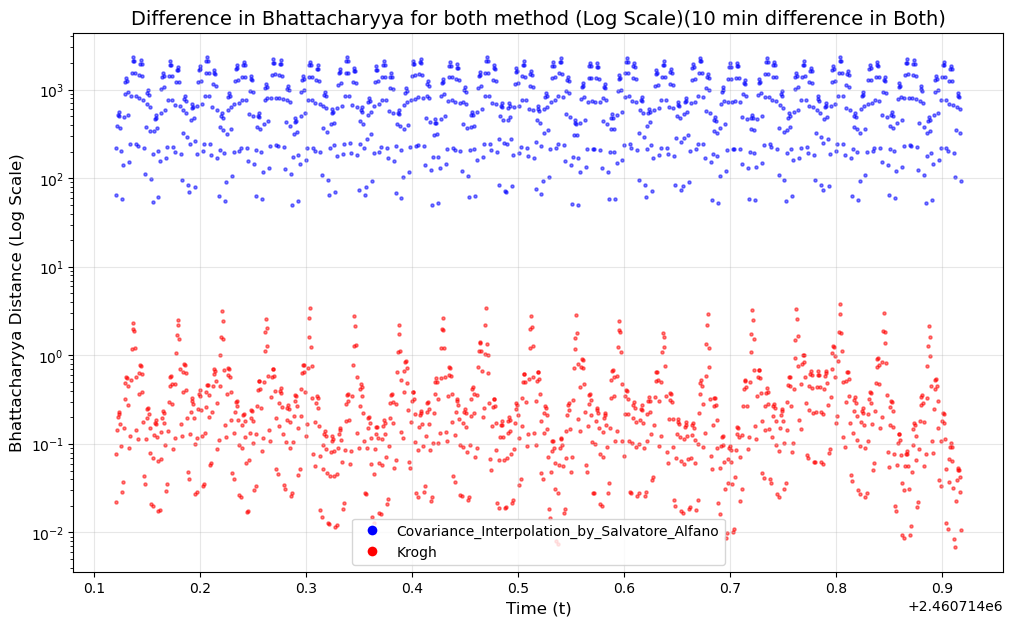

In [148]:
# Plot the results
import matplotlib.pyplot as plt

# Plot M_inter and M_qu vs time
plt.figure(figsize=(12, 7))

time = np.array([window['julian_date'] for window in all_diffs_10])
M_inter = np.array([window['M_inter'] for window in all_diffs_10])
M_qu = np.array([window['M_qu'] for window in all_diffs_10])
print(M_inter)
print(M_qu)
    
# Add a second plot for the difference between methods
plt.figure(figsize=(12, 7))
for i in range(len(time)):
    plt.scatter(time[i], M_inter[i], alpha=0.5, s=5, c='red')
    plt.scatter(time[i], M_qu[i], alpha=0.5, s=5, c='blue')

plt.yscale('log')
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Bhattacharyya Distance (Log Scale)', fontsize=12)
plt.title('Difference in Bhattacharyya for both method (Log Scale)(10 min difference in Both)', fontsize=14)
plt.grid(True, alpha=0.3)
# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Covariance_Interpolation_by_Salvatore_Alfano'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Krogh')
]
plt.legend(handles=legend_elements)
plt.show()
    

In [149]:
# Use all data points
data1 = skip_data_points(ori_data, 7,0)
data = skip_data_points(ori_data, 7,0)
data_11 = skip_data_points(ori_data, 0,0)

# Generate sigma points with validation
sigma_points_dict = generate_and_propagate_sigma_points(data1)
if sigma_points_dict is None:
    raise ValueError("Failed to generate sigma points")

# Create interpolation splines
interpolated_splinesKI = interpolate_sigma_pointsKI(sigma_points_dict)

# Use high precision for Julian date conversion
julian_dates = np.array([julian.to_jd(ts) for ts in data['timestamps']], dtype=np.float64)
state_vectors = np.hstack((data['positions'], data['velocities']))
covariances = data['covariances']

julian_dates_11 = np.array([julian.to_jd(ts) for ts in data_11['timestamps']], dtype=np.float64)
state_vectors_11 = np.hstack((data_11['positions'], data_11['velocities']))
covariances_11 = data_11['covariances']

# Initialize array to store differences
all_diffs_8 = []

# Loop through the dataset with proper windowing
# Start at index that ensures we have enough data for a complete window
start_idx = 0
# End at a point that ensures we don't exceed array bounds when accessing i+5
end_idx = len(covariances) - 5

for i in range(194, 337):
    # Get covariance matrices and state vectors for the window
    Pa = covariances[i]
    Pb = covariances[i+1]
    Pc = covariances[i+2]
    Pd = covariances[i+3]
    Pe = covariances[i+4]
    Pf = covariances[i+5]
    
    # Get Julian dates for the window boundaries
    j1 = julian_dates[i+2]
    j2 = julian_dates[i+3]
    
    # Get state vectors
    Sa = state_vectors[i]
    Sb = state_vectors[i+1]
    Sc = state_vectors[i+2]
    Sd = state_vectors[i+3]
    Se = state_vectors[i+4]
    Sf = state_vectors[i+5]
    
    # Unscented transform parameters
    n = 3
    alpha = np.float64(0.5)  # Reduced alpha for better numerical stability
    beta = np.float64(2.0)   # Optimal for Gaussian
    kappa = np.float64(3-n)  # Modified for better stability
    lambda_param = alpha * alpha * (n + kappa) - n
    
    # Precompute weights for efficiency and precision
    w0_m = lambda_param / (n + lambda_param)
    wn_m = np.float64(0.5) / (n + lambda_param)
    w0_c = w0_m + (1 - alpha * alpha + beta)
    wn_c = wn_m
    
    # Find all time points in data_11 that fall between j1 and j2
    mask = (julian_dates_11 > j1) & (julian_dates_11 < j2)
    time_points_between = julian_dates_11[mask]
    indices_between = np.where(mask)[0]
    
    # Skip this window if no points found
    if len(time_points_between) == 0:
        continue
    
    window_diffs = []
    
    # Process each time point that falls within the window
    for idx, jd in zip(indices_between, time_points_between):
        # Calculate interpolation parameter t based on relative position
        # t goes from 0 (at j1) to 1 (at j2)
        t = (jd - j1) / (j2 - j1) if j2 > j1 else 0.5
        
        # METHOD 1: Quintic spline interpolation (Salvatore Alfano's method)
        cov = positional_quintic_spline(t, Pa, Pb, Pc, Pd, Pe, Pf)
        state = positional_quintic_spline(t, Sa, Sb, Sc, Sd, Se, Sf)

        # METHOD 2: Krogh interpolation (using sigma points)
        interpolated_points = get_interpolated_sigma_points_KI(interpolated_splinesKI, jd)
        interp_mean, interp_cov = reconstruct_covariance_at_time(interpolated_points)

        # Get reference state at this point
        state_11 = state_vectors_11[idx]
        cov_11=covariances_11[idx]
        
        # Calculate Mahalanobis distances
        inte_maha = bhattacharyya_distance(state_11,cov_11, interp_mean, interp_cov)
        maha = bhattacharyya_distance(state_11,cov_11, state, cov)
        
        difference = inte_maha - maha
        #print(f"Window {i}, Julian date {jd}, t={t:.4f}: Difference = {difference}")
        
        # Store differences for this point
        window_diffs.append({
            'window_start': i,
            'julian_date': jd,
            'M_inter': inte_maha,
            'M_qu': maha,
            'diff': difference,
            't_value': t
        })
    
    # Add all window differences to the main list
    all_diffs_8.extend(window_diffs)
    


<Figure size 1200x700 with 0 Axes>

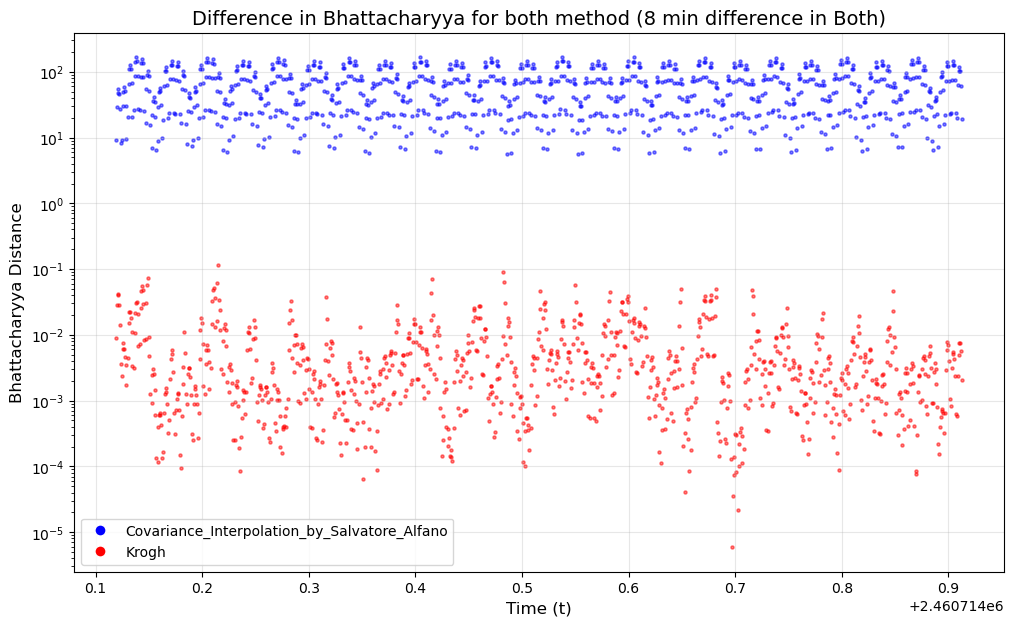

In [150]:
# Plot the results
import matplotlib.pyplot as plt

# Plot M_inter and M_qu vs time
plt.figure(figsize=(12, 7))

time = np.array([window['julian_date'] for window in all_diffs_8])
M_inter = np.array([window['M_inter'] for window in all_diffs_8])
M_qu = np.array([window['M_qu'] for window in all_diffs_8])


    
# Add a second plot for the difference between methods
plt.figure(figsize=(12, 7))
for i in range(len(time)):
    plt.scatter(time[i], M_inter[i], alpha=0.5, s=5, c='red')
    plt.scatter(time[i], M_qu[i], alpha=0.5, s=5, c='blue')

plt.yscale('log')
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Bhattacharyya Distance', fontsize=12)
plt.title('Difference in Bhattacharyya for both method (8 min difference in Both)', fontsize=14)
plt.grid(True, alpha=0.3)
# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Covariance_Interpolation_by_Salvatore_Alfano'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Krogh')
]
plt.legend(handles=legend_elements)
plt.show()
    

In [152]:
# Use all data points
data1 = skip_data_points(ori_data, 5,0)
data = skip_data_points(ori_data, 5,0)
data_11 = skip_data_points(ori_data, 0,0)

# Generate sigma points with validation
sigma_points_dict = generate_and_propagate_sigma_points(data1)
if sigma_points_dict is None:
    raise ValueError("Failed to generate sigma points")

# Create interpolation splines
interpolated_splinesKI = interpolate_sigma_pointsKI(sigma_points_dict)

# Use high precision for Julian date conversion
julian_dates = np.array([julian.to_jd(ts) for ts in data['timestamps']], dtype=np.float64)
state_vectors = np.hstack((data['positions'], data['velocities']))
covariances = data['covariances']

julian_dates_11 = np.array([julian.to_jd(ts) for ts in data_11['timestamps']], dtype=np.float64)
state_vectors_11 = np.hstack((data_11['positions'], data_11['velocities']))
covariances_11 = data_11['covariances']

# Initialize array to store differences
all_diffs_6 = []

# Loop through the dataset with proper windowing
# Start at index that ensures we have enough data for a complete window
start_idx = 0
# End at a point that ensures we don't exceed array bounds when accessing i+5
end_idx = len(covariances) - 5

for i in range(259, 450):
    # Get covariance matrices and state vectors for the window
    Pa = covariances[i]
    Pb = covariances[i+1]
    Pc = covariances[i+2]
    Pd = covariances[i+3]
    Pe = covariances[i+4]
    Pf = covariances[i+5]
    
    # Get Julian dates for the window boundaries
    j1 = julian_dates[i+2]
    j2 = julian_dates[i+3]
    
    # Get state vectors
    Sa = state_vectors[i]
    Sb = state_vectors[i+1]
    Sc = state_vectors[i+2]
    Sd = state_vectors[i+3]
    Se = state_vectors[i+4]
    Sf = state_vectors[i+5]
    
    # Unscented transform parameters
    n = 3
    alpha = np.float64(0.5)  # Reduced alpha for better numerical stability
    beta = np.float64(2.0)   # Optimal for Gaussian
    kappa = np.float64(3-n)  # Modified for better stability
    lambda_param = alpha * alpha * (n + kappa) - n
    
    # Precompute weights for efficiency and precision
    w0_m = lambda_param / (n + lambda_param)
    wn_m = np.float64(0.5) / (n + lambda_param)
    w0_c = w0_m + (1 - alpha * alpha + beta)
    wn_c = wn_m
    
    # Find all time points in data_11 that fall between j1 and j2
    mask = (julian_dates_11 > j1) & (julian_dates_11 < j2)
    time_points_between = julian_dates_11[mask]
    indices_between = np.where(mask)[0]
    
    # Skip this window if no points found
    if len(time_points_between) == 0:
        continue
    
    window_diffs = []
    
    # Process each time point that falls within the window
    for idx, jd in zip(indices_between, time_points_between):
        # Calculate interpolation parameter t based on relative position
        # t goes from 0 (at j1) to 1 (at j2)
        t = (jd - j1) / (j2 - j1) if j2 > j1 else 0.5
        
        # METHOD 1: Quintic spline interpolation (Salvatore Alfano's method)
        cov = positional_quintic_spline(t, Pa, Pb, Pc, Pd, Pe, Pf)
        state = positional_quintic_spline(t, Sa, Sb, Sc, Sd, Se, Sf)

        # METHOD 2: Krogh interpolation (using sigma points)
        interpolated_points = get_interpolated_sigma_points_KI(interpolated_splinesKI, jd)
        interp_mean, interp_cov = reconstruct_covariance_at_time(interpolated_points)

        # Get reference state at this point
        state_11 = state_vectors_11[idx]
        cov_11=covariances_11[idx]
        
        # Calculate Mahalanobis distances
        inte_maha = bhattacharyya_distance(state_11,cov_11, interp_mean, interp_cov)
        maha = bhattacharyya_distance(state_11,cov_11, state, cov)
        
        difference = inte_maha - maha
        #print(f"Window {i}, Julian date {jd}, t={t:.4f}: Difference = {difference}")
        
        # Store differences for this point
        window_diffs.append({
            'window_start': i,
            'julian_date': jd,
            'M_inter': inte_maha,
            'M_qu': maha,
            'diff': difference,
            't_value': t
        })
    
    # Add all window differences to the main list
    all_diffs_6.extend(window_diffs)
    

<Figure size 1200x700 with 0 Axes>

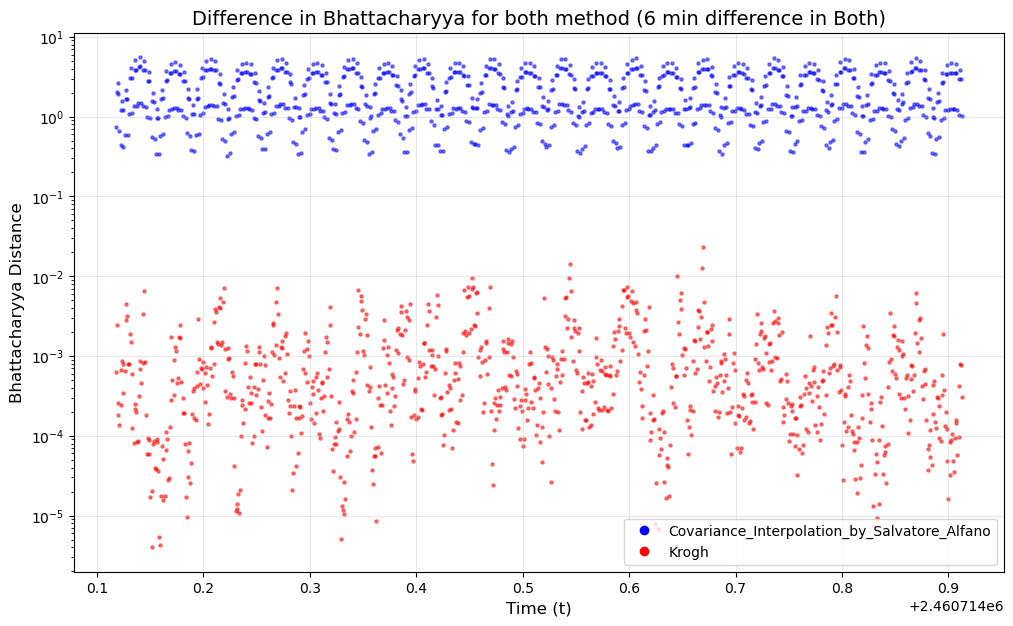

In [153]:
# Plot the results
import matplotlib.pyplot as plt

# Plot M_inter and M_qu vs time
plt.figure(figsize=(12, 7))

time = np.array([window['julian_date'] for window in all_diffs_6])
M_inter = np.array([window['M_inter'] for window in all_diffs_6])
M_qu = np.array([window['M_qu'] for window in all_diffs_6])


    
# Add a second plot for the difference between methods
plt.figure(figsize=(12, 7))
for i in range(len(time)):
    plt.scatter(time[i], M_inter[i], alpha=0.5, s=5, c='red')
    plt.scatter(time[i], M_qu[i], alpha=0.5, s=5, c='blue')

plt.yscale('log')
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Bhattacharyya Distance', fontsize=12)
plt.title('Difference in Bhattacharyya for both method (6 min difference in Both)', fontsize=14)
plt.grid(True, alpha=0.3)
# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Covariance_Interpolation_by_Salvatore_Alfano'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Krogh')
]
plt.legend(handles=legend_elements)
plt.show()
    

In [154]:
# Use all data points
data1 = skip_data_points(ori_data, 3,0)
data = skip_data_points(ori_data, 3,0)
data_11 = skip_data_points(ori_data, 0,0)

# Generate sigma points with validation
sigma_points_dict = generate_and_propagate_sigma_points(data1)
if sigma_points_dict is None:
    raise ValueError("Failed to generate sigma points")

# Create interpolation splines
interpolated_splinesKI = interpolate_sigma_pointsKI(sigma_points_dict)

# Use high precision for Julian date conversion
julian_dates = np.array([julian.to_jd(ts) for ts in data['timestamps']], dtype=np.float64)
state_vectors = np.hstack((data['positions'], data['velocities']))
covariances = data['covariances']

julian_dates_11 = np.array([julian.to_jd(ts) for ts in data_11['timestamps']], dtype=np.float64)
state_vectors_11 = np.hstack((data_11['positions'], data_11['velocities']))
covariances_11 = data_11['covariances']

# Initialize array to store differences
all_diffs_4 = []

# Loop through the dataset with proper windowing
# Start at index that ensures we have enough data for a complete window
start_idx = 0
# End at a point that ensures we don't exceed array bounds when accessing i+5
end_idx = len(covariances) - 5

for i in range(388, 675):
    # Get covariance matrices and state vectors for the window
    Pa = covariances[i]
    Pb = covariances[i+1]
    Pc = covariances[i+2]
    Pd = covariances[i+3]
    Pe = covariances[i+4]
    Pf = covariances[i+5]
    
    # Get Julian dates for the window boundaries
    j1 = julian_dates[i+2]
    j2 = julian_dates[i+3]
    
    # Get state vectors
    Sa = state_vectors[i]
    Sb = state_vectors[i+1]
    Sc = state_vectors[i+2]
    Sd = state_vectors[i+3]
    Se = state_vectors[i+4]
    Sf = state_vectors[i+5]
    
    # Unscented transform parameters
    n = 3
    alpha = np.float64(0.5)  # Reduced alpha for better numerical stability
    beta = np.float64(2.0)   # Optimal for Gaussian
    kappa = np.float64(3-n)  # Modified for better stability
    lambda_param = alpha * alpha * (n + kappa) - n
    
    # Precompute weights for efficiency and precision
    w0_m = lambda_param / (n + lambda_param)
    wn_m = np.float64(0.5) / (n + lambda_param)
    w0_c = w0_m + (1 - alpha * alpha + beta)
    wn_c = wn_m
    
    # Find all time points in data_11 that fall between j1 and j2
    mask = (julian_dates_11 > j1) & (julian_dates_11 < j2)
    time_points_between = julian_dates_11[mask]
    indices_between = np.where(mask)[0]
    
    # Skip this window if no points found
    if len(time_points_between) == 0:
        continue
    
    window_diffs = []
    
    # Process each time point that falls within the window
    for idx, jd in zip(indices_between, time_points_between):
        # Calculate interpolation parameter t based on relative position
        # t goes from 0 (at j1) to 1 (at j2)
        t = (jd - j1) / (j2 - j1) if j2 > j1 else 0.5
        
        # METHOD 1: Quintic spline interpolation (Salvatore Alfano's method)
        cov = positional_quintic_spline(t, Pa, Pb, Pc, Pd, Pe, Pf)
        state = positional_quintic_spline(t, Sa, Sb, Sc, Sd, Se, Sf)

        # METHOD 2: Krogh interpolation (using sigma points)
        interpolated_points = get_interpolated_sigma_points_KI(interpolated_splinesKI, jd)
        interp_mean, interp_cov = reconstruct_covariance_at_time(interpolated_points)

        # Get reference state at this point
        state_11 = state_vectors_11[idx]
        cov_11=covariances_11[idx]
        
        # Calculate Mahalanobis distances
        inte_maha = bhattacharyya_distance(state_11,cov_11, interp_mean, interp_cov)
        maha = bhattacharyya_distance(state_11,cov_11, state, cov)
        
        difference = inte_maha - maha
        #print(f"Window {i}, Julian date {jd}, t={t:.4f}: Difference = {difference}")
        
        # Store differences for this point
        window_diffs.append({
            'window_start': i,
            'julian_date': jd,
            'M_inter': inte_maha,
            'M_qu': maha,
            'diff': difference,
            't_value': t
        })
    
    # Add all window differences to the main list
    all_diffs_4.extend(window_diffs)
    

<Figure size 1200x700 with 0 Axes>

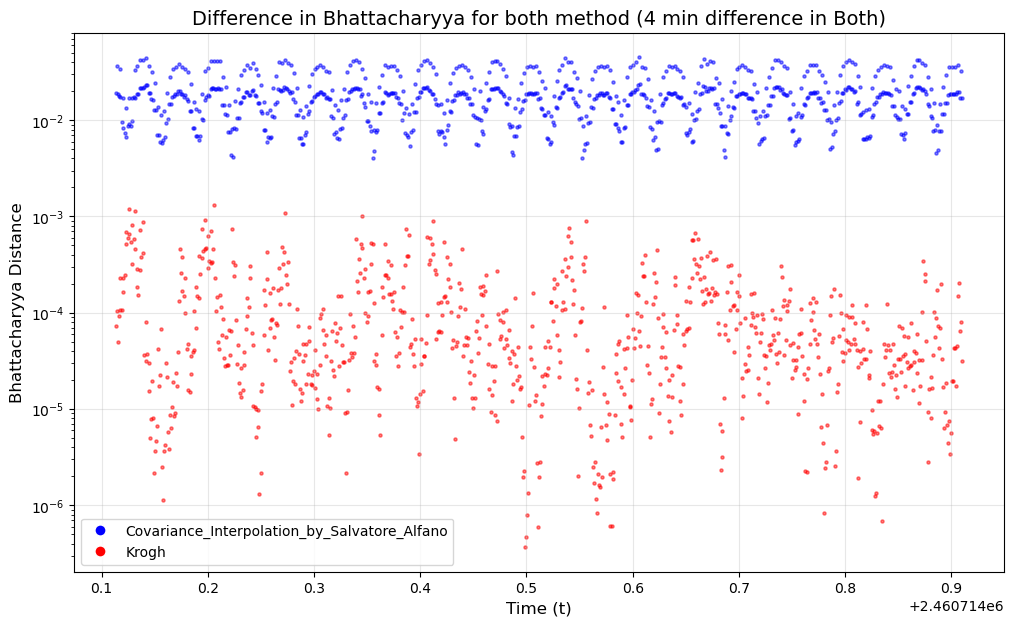

In [155]:
# Plot the results
import matplotlib.pyplot as plt

# Plot M_inter and M_qu vs time
plt.figure(figsize=(12, 7))

time = np.array([window['julian_date'] for window in all_diffs_4])
M_inter = np.array([window['M_inter'] for window in all_diffs_4])
M_qu = np.array([window['M_qu'] for window in all_diffs_4])


    
# Add a second plot for the difference between methods
plt.figure(figsize=(12, 7))
for i in range(len(time)):
    plt.scatter(time[i], M_inter[i], alpha=0.5, s=5, c='red')
    plt.scatter(time[i], M_qu[i], alpha=0.5, s=5, c='blue')

plt.yscale('log')
plt.xlabel('Time (t)', fontsize=12)
plt.ylabel('Bhattacharyya Distance', fontsize=12)
plt.title('Difference in Bhattacharyya for both method (4 min difference in Both)', fontsize=14)
plt.grid(True, alpha=0.3)
# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Covariance_Interpolation_by_Salvatore_Alfano'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Krogh')
]
plt.legend(handles=legend_elements)
plt.show()
    

Statistical Summary:
   Gap (min)  Krogh Mean  Krogh Std Dev  Quintic Mean  Quintic Std Dev
0          2    0.000116       0.000170      0.018798         0.009623
1          4    0.001037       0.001698      2.118065         1.356282
2          6    0.006421       0.010693     61.069025        43.130041
3          8    0.377761       0.535875    816.050085       615.466772


/var/folders/1_/l5p8yy_x2d5flcqc9w5tbg3m0000gn/T/ipykernel_39108/1015504971.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 120x120 with 0 Axes>

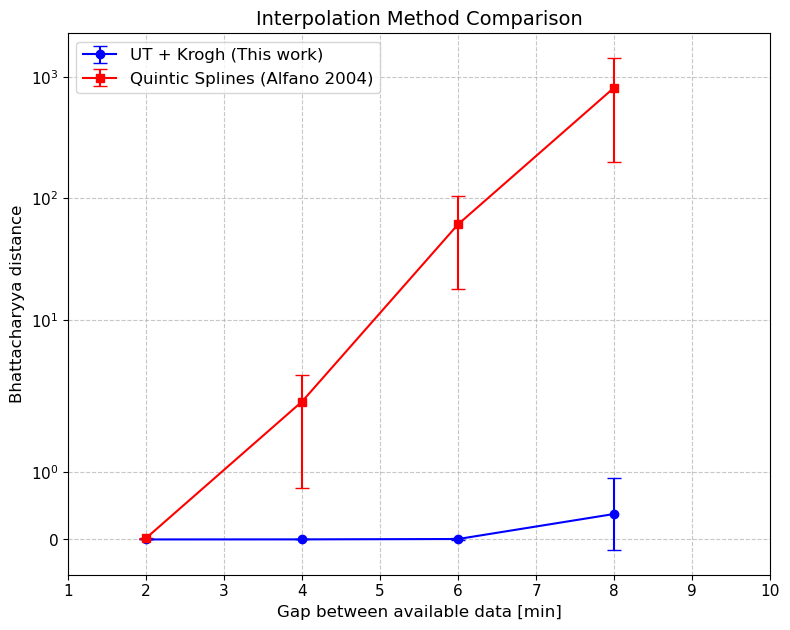

'\nplt.figure(figsize=(12, 8))\n\n# Define more methods (example - adjust based on your actual data)\nmethods = {\n    \'Cubic Spline\': {\'means\': [val*0.1 for val in m_qu_means], \'stds\': [val*0.1 for val in m_qu_stds], \'color\': \'black\', \'marker\': \'o\'},\n    \'Cubic Hermite Spline\': {\'means\': m_qu_means, \'stds\': m_qu_stds, \'color\': \'red\', \'marker\': \'s\'},\n    \'BPoly\': {\'means\': [val*10 for val in m_qu_means], \'stds\': [val*5 for val in m_qu_stds], \'color\': \'green\', \'marker\': \'^\'},\n    \'KroghInterpolator\': {\'means\': m_inter_means, \'stds\': m_inter_stds, \'color\': \'blue\', \'marker\': \'d\'}\n}\n\n# Plot each method\nfor i, (name, data) in enumerate(methods.items()):\n    offset = (i - 1.5) * 0.1  # Distribute points around x-value\n    plt.errorbar(np.array(x_values) + offset, data[\'means\'], yerr=data[\'stds\'], \n                 fmt=f"{data[\'marker\']}-", capsize=5, color=data[\'color\'], label=name)\n\nplt.yscale(\'symlog\')\nplt.grid(

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming all_diffs_4, all_diffs_6, all_diffs_8, all_diffs_10 are lists of dictionaries
# with the same structure as in your code

# Function to extract statistics from each array
def extract_stats(diff_array):
    m_inter_values = [item['M_inter'] for item in diff_array]
    m_qu_values = [item['M_qu'] for item in diff_array]
    
    return {
        'M_inter_mean': np.mean(m_inter_values),
        'M_inter_std': np.std(m_inter_values),
        'M_qu_mean': np.mean(m_qu_values),
        'M_qu_std': np.std(m_qu_values)
    }

# Calculate statistics for each array
# Replace with your actual arrays if needed
stats_4 = extract_stats(all_diffs_4)
stats_6 = extract_stats(all_diffs_6)
stats_8 = extract_stats(all_diffs_8)
stats_10 = extract_stats(all_diffs_10)

# X-axis values (measurement gaps in minutes)
# Assuming these correspond to 4, 6, 8, 10 from your original arrays
# Adjust these values to match your actual measurement gaps
x_values = [2, 4, 6, 8]  # Measurement gaps in minutes

# Extract statistics into lists for plotting
m_inter_means = [stats_4['M_inter_mean'], stats_6['M_inter_mean'], 
                 stats_8['M_inter_mean'], stats_10['M_inter_mean']]
m_inter_stds = [stats_4['M_inter_std'], stats_6['M_inter_std'], 
                stats_8['M_inter_std'], stats_10['M_inter_std']]

m_qu_means = [stats_4['M_qu_mean'], stats_6['M_qu_mean'], 
              stats_8['M_qu_mean'], stats_10['M_qu_mean']]
m_qu_stds = [stats_4['M_qu_std'], stats_6['M_qu_std'], 
             stats_8['M_qu_std'], stats_10['M_qu_std']]

# Create figure with logarithmic y-scale
plt.figure(figsize=(0.8,0.8),dpi=150)

# Scale the plot size by 0.8 to make fonts appear larger relative to plot size
fig, ax = plt.subplots(figsize=(8, 6.4))  # 0.8 * original size

# Plot with error bars for each method
ax.errorbar(np.array(x_values), m_inter_means, yerr=m_inter_stds, 
           fmt='o-', capsize=5, color='blue', label='UT + Krogh (This work)')
ax.errorbar(np.array(x_values), m_qu_means, yerr=m_qu_stds, 
           fmt='s-', capsize=5, color='red', label='Quintic Splines (Alfano 2004)')

# Set y-axis to logarithmic scale
ax.set_yscale('symlog')  # Symlog allows both positive and negative values on log scale

# Add grid, labels, and title
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('Gap between available data [min]', fontsize=12)
ax.set_ylabel('Bhattacharyya distance', fontsize=12)
ax.set_title('Interpolation Method Comparison', fontsize=14)
ax.legend(fontsize=12)

# Set appropriate x-axis range and ticks
ax.set_xlim(1, 10)
ax.set_xticks(range(1, 11))

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=11)

# Adjust layout
plt.tight_layout()
# Create a table with the exact values
data = {
    'Gap (min)': x_values,
    'Krogh Mean': m_inter_means,
    'Krogh Std Dev': m_inter_stds,
    'Quintic Mean': m_qu_means,
    'Quintic Std Dev': m_qu_stds
}
df = pd.DataFrame(data)
print("Statistical Summary:")
print(df)

plt.tight_layout()
plt.show()

# Alternative version with more methods (similar to your example image)
# Uncomment and modify if you have more methods to compare



In [ ]:
cov = np.array([
    [0.52, 0.14, 0.89, 0.33, 0.71, 0.61],
    [0.41, 0.76, 0.03, 0.85, 0.47, 0.59],
    [0.67, 0.29, 0.91, 0.64, 0.12, 0.75],
    [0.36, 0.53, 0.27, 0.98, 0.22, 0.08],
    [0.10, 0.95, 0.55, 0.31, 0.87, 0.44],
    [0.18, 0.70, 0.63, 0.45, 0.28, 0.39]
])

state = np.array([
    [0.35],
    [0.72],
    [0.18],
    [0.64],
    [0.93],
    [0.50]
])

print(bhattacharyya_distance(state,cov,state,cov))

In [158]:
i_r=[1,0,0]
i_t=[0,1,0]
i_n=[0,0,1]

Q = np.vstack([i_r, i_t, i_n])
print(Q)

[[1 0 0]
 [0 1 0]
 [0 0 1]]
